In [1]:
%cd ../
## Autorreload all the files
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import numpy as np
from src.spline import *

print("Device cuda: ", torch.cuda.is_available())

f:\MonoKAN
Device cuda:  True


In [2]:
in_dim, out_dim = 3,2
num=5
k=3
bs = 100

x = torch.rand(bs, in_dim)
y = torch.rand(bs, out_dim)

grid = extend_grid(torch.linspace(-1, 1, num+1).repeat(in_dim, 1), k_extend=k)
print("Grid shape: ", grid.shape)

noises = (torch.rand(num+1, in_dim, out_dim) - 1/2) * .5 / num
coef = curve2coef(grid[:, k:-k].permute(1, 0), noises, grid, k)
scale_sp = torch.ones(in_dim, out_dim) / np.sqrt(in_dim)

scale_base = (torch.rand(in_dim, out_dim) * 2-1)/np.sqrt(in_dim)
print("Scale base shape: ", scale_base.shape)
base_fun=nn.SiLU()

# scale_base = torch.zeros(in_dim, out_dim)
# base_fun=nn.Identity()



Grid shape:  torch.Size([3, 12])
Scale base shape:  torch.Size([3, 2])


In [ ]:
import torch
in_dim, out_dim = 10, 3

in_coord = torch.arange(in_dim) * 1/in_dim + 1/(2*in_dim)
out_coord = torch.arange(out_dim) * 1/out_dim + 1/(2*out_dim)

# print(in_coord, out_coord)

dist_mat = torch.abs(out_coord[:,None] - in_coord[None,:])
# print(dist_mat)

in_nearest = torch.argmin(dist_mat, dim=0)
in_connection = torch.stack([torch.arange(in_dim), in_nearest]).permute(1,0)
out_nearest = torch.argmin(dist_mat, dim=1)
out_connection = torch.stack([out_nearest, torch.arange(out_dim)]).permute(1,0)
all_connection = torch.cat([in_connection, out_connection], dim=0)
mask = torch.zeros(in_dim, out_dim)
mask[all_connection[:,0], all_connection[:,1]] = 1.
mask

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])

In [34]:
in_dim, out_dim = 9, 3

in_coord = (torch.arange(in_dim) + 0.5) / in_dim
out_coord = (torch.arange(out_dim) + 0.5) / out_dim

in_to_out = torch.argmin(torch.abs(out_coord[None, :] - in_coord[:, None]), dim=1)
out_to_in = torch.argmin(torch.abs(in_coord[None, :] - out_coord[:, None]), dim=1)

mask = torch.zeros(in_dim, out_dim)
mask[torch.arange(in_dim), in_to_out] = 1.0
mask[out_to_in, torch.arange(out_dim)] = 1.0
mask

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])

In [5]:
bs = x.shape[0]
preacts = x[:, None, :].clone().expand(bs, out_dim, in_dim)
y = coef2curve(x, grid, coef, k)  # bs, in_dim, out_dim

postspline = y.clone().permute(0,2,1)  # bs, out_dim, in_dim
base = base_fun(x)

y = scale_base[None, :, :] * base[:, :, None] + scale_sp[None, :, :] * y

postacts = y.clone().permute(0,2,1)  # bs, out_dim, in_dim

y = torch.sum(y, dim=1)  # bs, in_dim
y.shape

torch.Size([100, 2])

checkpoint directory created: ./model
saving model version 0.0
torch.Size([1000, 9]) torch.Size([1000, 3])


| train_loss: 1.46e-01 | test_loss: 1.51e-01 | reg: 2.61e+01 | : 100%|█| 20/20 [05:18<00:00, 15.93s/


saving model version 0.1


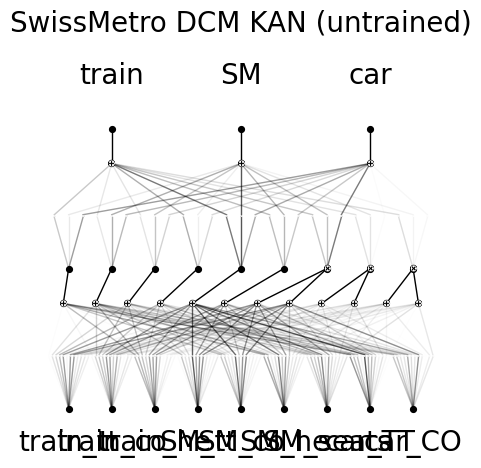

In [35]:
import torch
import numpy as np

# import matplotlib
# matplotlib.use("QT5Agg")  # 使用Qt5后端
import matplotlib.pyplot as plt

from kan import KAN


def create_dcm_swissmetro_dataset(
    train_num=1000,
    test_num=1000,
    ranges=[-2, 2],  # 比如特征范围设宽一点
    noise_std=0.1,  # 噪声强度
    normalize_input=False,
    normalize_label=False,
    device="cpu",
    seed=0,
):
    """
    生成SwissMetro DCM三备选 synthetic 数据集，含线性项和交互项

    Args:
    -----
        train_num : int
            训练样本数
        test_num : int
            测试样本数
        ranges : list, (2,) or (n_var, 2)
            特征范围（每个特征的min,max），支持统一/分特征
        noise_std : float
            效用扰动高斯噪声标准差
        normalize_input : bool
            是否归一化输入
        normalize_label : bool
            是否归一化输出
        device : str
            设备
        seed : int
            随机种子

    Returns:
    -------
        dataset : dict
            'train_input':  (train_num, 9)
            'test_input':   (test_num, 9)
            'train_label':  (train_num, 3)
            'test_label':   (test_num, 3)
    """

    np.random.seed(seed)
    torch.manual_seed(seed)
    n_var = 9

    # 统一范围/分特征范围
    if len(np.array(ranges).shape) == 1:
        ranges = np.array(ranges * n_var).reshape(n_var, 2)
    else:
        ranges = np.array(ranges)

    def sample_input(num):
        x = torch.zeros(num, n_var)
        for i in range(n_var):
            x[:, i] = torch.rand(num) * (ranges[i, 1] - ranges[i, 0]) + ranges[i, 0]
        return x

    train_input = sample_input(train_num)
    test_input = sample_input(test_num)

    # 别名: x[0~2] = train, x[3~6] = SM, x[7~8] = car
    def utility_func(x):
        # x: [batch, 9]
        # beta, gamma: 任意设置，可微调
        # train
        u_train = (
            -2.0 * x[:, 0]  # train_tt
            - 1.5 * x[:, 1]  # train_co
            - 0.5 * x[:, 2]  # train_he
            + 1.0 * x[:, 0] * x[:, 2]  # interaction: train_tt * train_he
        )
        # SM
        u_sm = (
            -2.2 * x[:, 3]  # SM_tt
            - 1.4 * x[:, 4]  # SM_co
            - 0.8 * x[:, 5]  # SM_he
            + 1.2 * x[:, 3] * x[:, 5]  # interaction: SM_tt * SM_he
            + 0.6 * x[:, 6]  # SM_seats
        )
        # car
        u_car = (
            -1.8 * x[:, 7]  # car_TT
            - 2.1 * x[:, 8]  # car_CO
            + 0.7 * x[:, 7] * x[:, 8]  # interaction: car_TT * car_CO
        )
        # 叠加高斯噪声
        batch = x.shape[0]
        noise = noise_std * torch.randn(batch, 3)
        return torch.stack([u_train, u_sm, u_car], dim=1) + noise

    train_label = utility_func(train_input)
    test_label = utility_func(test_input)

    def normalize(data, mean, std):
        return (data - mean) / std

    if normalize_input:
        mean_input = torch.mean(train_input, dim=0, keepdim=True)
        std_input = torch.std(train_input, dim=0, keepdim=True)
        train_input = normalize(train_input, mean_input, std_input)
        test_input = normalize(test_input, mean_input, std_input)
    if normalize_label:
        mean_label = torch.mean(train_label, dim=0, keepdim=True)
        std_label = torch.std(train_label, dim=0, keepdim=True)
        train_label = normalize(train_label, mean_label, std_label)
        test_label = normalize(test_label, mean_label, std_label)

    dataset = dict(
        train_input=train_input.to(device),
        test_input=test_input.to(device),
        train_label=train_label.to(device),
        test_label=test_label.to(device),
    )
    return dataset


def test_multikan():

    width = [
        [9, 0],  # 9 input features
        [6, 3],  # 6 sum nodes, 3 mult nodes (for 3 pairwise interactions)
        [3, 0],  # 3 outputs (utility for each alternative)
    ]
    mult_arity = [
        [],  # input layer: no mult node
        [2, 2, 2],  # each mult node does two-way interaction
        [],  # output layer
    ]
    kan = KAN(width, mult_arity=2, device="cuda")

    dataset = create_dcm_swissmetro_dataset(
        train_num=1000, test_num=1000, device="cuda"
    )
    print(dataset["train_input"].shape, dataset["train_label"].shape)
    kan(dataset["train_input"])
    kan.plot(
        in_vars=[
            "train_tt",
            "train_co",
            "train_he",
            "SM_tt",
            "SM_co",
            "SM_he",
            "SM_seats",
            "car_TT",
            "car_CO",
        ],
        out_vars=["train", "SM", "car"],
        title="SwissMetro DCM KAN (untrained)",
    )
    # plt.show()

    # 训练KAN模型
    kan.fit(
        dataset,
        opt="LBFGS",
        steps=20,
        lamb=0.01,
        in_vars=[
            "train_tt",
            "train_co",
            "train_he",
            "SM_tt",
            "SM_co",
            "SM_he",
            "SM_seats",
            "car_TT",
            "car_CO",
        ],
        out_vars=["train", "SM", "car"],
        save_fig=True
    )
    # kan.plot(
    #     in_vars=[
    #         "train_tt",
    #         "train_co",
    #         "train_he",
    #         "SM_tt",
    #         "SM_co",
    #         "SM_he",
    #         "SM_seats",
    #         "car_TT",
    #         "car_CO",
    #     ],
    #     out_vars=["train", "SM", "car"],
    #     title="SwissMetro DCM KAN (trained)",
    # )
    # plt.show()
    return


if __name__ == "__main__":
    test_multikan()
    # print("Test completed successfully.")

In [68]:
from src.KANLayer import *

in_dim, out_dim = 2, 4
bs=3

kan_layer = KANLayer(in_dim=in_dim, out_dim=out_dim, num=5, k=3, include_basis=True, sparse_init=True, grid_range=[-1, 1], device="cuda")
x = torch.rand(bs, in_dim).to("cuda")
y, preacts, postacts, postspline = kan_layer(x)
y.shape

torch.Size([3, 4])

In [74]:
print("postacts sum dim2", postacts.sum(dim=2))
print("postspline sum dim 2", postspline.sum(dim=2))
print("masks", kan_layer.mask)
print("basis", (kan_layer.scale_base[None, :, :] * kan_layer.base_fun(x)[:, :, None]).sum(dim=1))
print("output", y)

postacts sum dim2 tensor([[ 0.0592, -0.0182, -0.1242, -0.3608],
        [ 0.3453,  0.0459, -0.0256, -0.0068],
        [-0.0072, -0.0187, -0.1825, -0.4261]], device='cuda:0',
       grad_fn=<SumBackward1>)
postspline sum dim 2 tensor([[-0.0623, -0.0695,  0.0245, -0.0300],
        [ 0.0465,  0.0536, -0.0099,  0.0069],
        [-0.0379, -0.0312,  0.0249,  0.0071]], device='cuda:0',
       grad_fn=<SumBackward1>)
masks Parameter containing:
tensor([[1., 1., 0., 0.],
        [0., 0., 1., 1.]], device='cuda:0')
basis tensor([[-0.0455, -0.2746, -0.1004, -0.3688],
        [ 0.3062,  0.0180,  0.1395, -0.0762],
        [-0.1472, -0.3531, -0.1680, -0.4448]], device='cuda:0',
       grad_fn=<SumBackward1>)
output tensor([[ 0.0592, -0.0182, -0.1242, -0.3608],
        [ 0.3453,  0.0459, -0.0256, -0.0068],
        [-0.0072, -0.0187, -0.1825, -0.4261]], device='cuda:0',
       grad_fn=<SumBackward1>)
